In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import random

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.GELU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), 
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.GELU(),
        )
        self.m = nn.Sigmoid()
        
        channels = out_channels
        
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.GELU(),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        self.up = []
        
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.GELU(),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

In [ ]:
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image1 = Image.open('/content/drive/MyDrive/test/test_input_20010.png').convert('RGB')

In [ ]:
image2 = Image.open('/content/drive/MyDrive/test/test_input_20010.png')

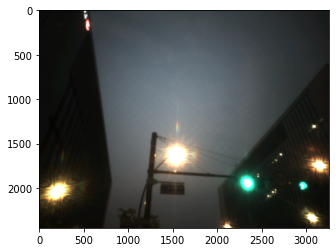

In [ ]:
plt.imshow(np.transpose(image2,(0,1,2)))

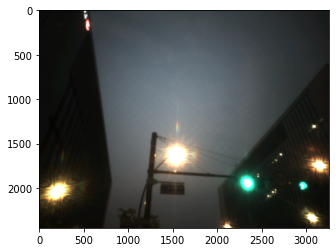

In [ ]:
plt.imshow(np.transpose(image1,(0,1,2)))

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((384, 512))
        ])

In [ ]:
image1 = transform(image1)

In [ ]:
image2 = transform(image2)

In [ ]:
GAB = GeneratorResNet(3,5)

In [ ]:
GBA = GeneratorResNet(3,5)

In [ ]:
output1 = GAB(image1.reshape(1,3,384,512))

In [ ]:
output2 = GBA(image2.reshape(1,3,384,512))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


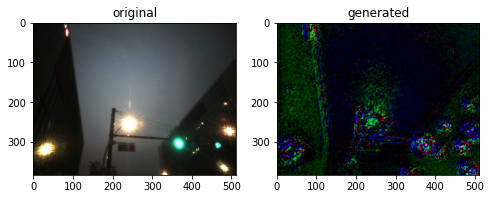

In [ ]:
fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
ax[0].set_title('original')
ax[0].imshow(np.moveaxis(image1.cpu().numpy(),0,2))
out = output1.detach().cpu()
ax[1].set_title('generated')
ax[1].imshow(np.moveaxis(out.reshape(3,384,512).cpu().numpy(),0,2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


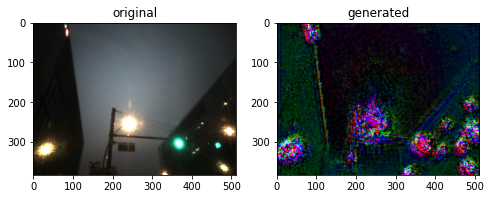

In [ ]:
fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
ax[0].set_title('original')
ax[0].imshow(np.moveaxis(image2.cpu().numpy(),0,2))
out = output2.detach().cpu()
ax[1].set_title('generated')
ax[1].imshow(np.moveaxis(out.reshape(3,384,512).cpu().numpy(),0,2))